# Heart Disease UCI – 2.4 Supervised Learning (Feature Selection vs PCA)

## Introduction
This notebook evaluates four supervised classifiers on two prepared feature views of the Heart Disease UCI dataset: (1) Selected Features (manual / importance-driven subset) and (2) PCA Reduced Components (variance-preserving projection). The goal is to compare predictive performance and determine which representation + model pair yields superior generalization.

**Models Evaluated:** Logistic Regression, Decision Tree, Random Forest, Support Vector Machine (SVM).

**Metrics:** Accuracy, Precision, Recall, F1, ROC AUC, plus ROC curves per dataset.

**Deliverables:**
- Clean reproducible pipeline (train/test split 80/20 stratified) for both datasets.
- Unified evaluation function producing metric tables.
- ROC comparison plots (one per dataset).
- Side-by-side tables + final summary highlighting best-performing model & representation.

---

## 1. Imports & Configuration

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report)

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 110
print('Imports ready.')

Imports ready.


## 2. Load Datasets

In [10]:
# Attempt to load both datasets with graceful fallback for PCA filename variants.
DATA_DIR = Path('../data')
selected_path = DATA_DIR / 'selected_features.csv'
pca_primary = DATA_DIR / 'pca_reduced_data.csv'          # Name per spec
pca_alt = DATA_DIR / 'pca_reduced_components.csv'        # Name actually produced earlier
pca_path = pca_primary if pca_primary.exists() else pca_alt
if not selected_path.exists():
    raise FileNotFoundError(f'Missing expected file: {selected_path}')
if not pca_path.exists():
    raise FileNotFoundError('Neither pca_reduced_data.csv nor pca_reduced_components.csv found.')

# Load
df_selected = pd.read_csv(selected_path)
df_pca = pd.read_csv(pca_path)

# Determine / unify target column between datasets
possible_targets = ['num', 'target']
sel_target = next((c for c in possible_targets if c in df_selected.columns), None)
pca_target = next((c for c in possible_targets if c in df_pca.columns), None)

if sel_target is None and pca_target is None:
    raise ValueError('No target column (num/target) found in either dataset.')

# If PCA missing target, try to copy from selected (lengths must match)
if pca_target is None:
    source_col = sel_target
    if len(df_selected) != len(df_pca):
        raise ValueError('PCA dataframe length differs from selected; cannot align target.')
    df_pca[source_col] = df_selected[source_col].values
    pca_target = source_col
    print(f"Injected target column '{source_col}' into PCA dataframe.")

# If selected missing target but PCA has it (unlikely), copy back
if sel_target is None:
    source_col = pca_target
    if len(df_selected) != len(df_pca):
        raise ValueError('Selected dataframe length differs from PCA; cannot align target.')
    df_selected[source_col] = df_pca[source_col].values
    sel_target = source_col
    print(f"Injected target column '{source_col}' into Selected Features dataframe.")

# If both exist but names differ, standardize to sel_target
if sel_target != pca_target:
    # Rename PCA target to sel_target
    df_pca.rename(columns={pca_target: sel_target}, inplace=True)
    print(f"Renamed PCA target column '{pca_target}' to '{sel_target}'.")

TARGET_COL = sel_target  # unified
print('Unified target column:', TARGET_COL)

print('Selected Features shape:', df_selected.shape)
print('PCA Reduced shape:', df_pca.shape)
df_selected.head()

Renamed PCA target column 'target' to 'num'.
Unified target column: num
Selected Features shape: (920, 18)
PCA Reduced shape: (920, 16)


,cp_non-anginal,fbs_True,exang_True,chol,chol_per_age,ca,trestbps,slope_flat,sex_Male,heart_rate_reserve,oldpeak,thalch,thal_normal,slope_upsloping,cp_atypical angina,thal_reversable defect,age,num
0,False,True,False,233.0,3.698412,0,145.0,False,True,5.0,2.3,150.0,False,False,False,False,63,0
1,False,False,True,286.0,4.268656,3,160.0,True,True,-52.0,1.5,108.0,True,False,False,False,67,1
2,False,False,True,229.0,3.417910,2,120.0,True,True,9.0,2.6,129.0,False,False,False,True,67,1
3,True,False,False,250.0,6.756755,0,130.0,False,True,57.0,3.5,187.0,True,False,False,False,37,0
4,False,False,False,204.0,4.975609,0,130.0,False,False,42.0,1.4,172.0,True,True,True,False,41,0


### Quick Peek – PCA Reduced

In [11]:
df_pca.head()

,num,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0,-0.489549,2.182384,-1.822361,0.767597,0.200556,1.045469,3.454578,2.800170,1.325818,-0.920846,-0.152528,0.288618,0.511381,0.971526,0.128180
1,1,-2.692351,1.923359,0.221825,-2.201416,-0.362671,-0.291906,0.538385,-0.541987,-1.085232,2.298472,-0.006350,1.256341,1.408190,-1.542364,-0.681537
2,1,-2.616191,0.075019,0.614685,1.166307,0.482672,-0.151829,0.580845,-0.256370,-1.800568,0.952024,0.225565,-0.133076,0.794470,-0.669090,-0.198288
3,0,2.794853,0.295663,1.294772,1.061320,1.935885,1.210252,1.211643,-1.243387,0.374942,-0.577287,1.626042,0.732496,1.612965,1.335566,-0.122445
4,0,3.929070,0.068443,-0.302623,-0.144740,-0.328114,-1.808626,0.683949,-0.488551,-0.917535,-0.948324,1.178306,-0.164508,-0.124632,0.558791,-0.195461


## 3. Train-Test Split (Both Representations)

In [12]:
def prepare_xy(df: pd.DataFrame):
    if TARGET_COL not in df.columns:
        raise KeyError(f'Target column {TARGET_COL} not found in dataframe.')
    y = df[TARGET_COL].copy()
    # Ensure binary (convert >0 to 1 if multi-class remnants)
    if y.nunique() > 2:
        y = (y > 0).astype(int)
    X = df.drop(columns=[TARGET_COL])
    return X, y

X_sel, y_sel = prepare_xy(df_selected)
X_pca, y_pca = prepare_xy(df_pca)

Xsel_train, Xsel_test, ysel_train, ysel_test = train_test_split(
    X_sel, y_sel, test_size=0.2, stratify=y_sel, random_state=42)
Xpca_train, Xpca_test, ypca_train, ypca_test = train_test_split(
    X_pca, y_pca, test_size=0.2, stratify=y_pca, random_state=42)

print('Selected Split:', Xsel_train.shape, Xsel_test.shape)
print('PCA Split:', Xpca_train.shape, Xpca_test.shape)

Selected Split: (736, 17) (184, 17)
PCA Split: (736, 15) (184, 15)


## 4. Helper: Model Definitions & Evaluation Function

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, solver='liblinear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

def evaluate_models(X_train, X_test, y_train, y_test, scale=False):
    metric_rows = []
    roc_store = {}  # name -> (fpr, tpr, auc)
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_store[name] = (fpr, tpr, auc)
        metric_rows.append({
            'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc
        })
        print(f"\n=== {name} Classification Report ===")
        print(classification_report(y_test, y_pred, digits=3))
    metrics_df = pd.DataFrame(metric_rows).set_index('Model').sort_values('AUC', ascending=False)
    return metrics_df, roc_store
print('Helper functions ready.')

Helper functions ready.


## 5. Model Training & Evaluation – Selected Features

In [14]:
sel_metrics, sel_roc = evaluate_models(Xsel_train, Xsel_test, ysel_train, ysel_test, scale=True)
print('\nSelected Features Metrics:')
display(sel_metrics.round(4))


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0      0.865     0.780     0.821        82
           1      0.836     0.902     0.868       102

    accuracy                          0.848       184
   macro avg      0.851     0.841     0.844       184
weighted avg      0.849     0.848     0.847       184


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0      0.765     0.793     0.778        82
           1      0.828     0.804     0.816       102

    accuracy                          0.799       184
   macro avg      0.796     0.798     0.797       184
weighted avg      0.800     0.799     0.799       184


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0      0.857     0.805     0.830        82
           1      0.850     0.892     0.871       102

    accuracy                          0.8

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.8478,0.8364,0.9020,0.8679,0.9099
Random Forest,0.8533,0.8505,0.8922,0.8708,0.9080
SVM,0.8533,0.8319,0.9216,0.8744,0.9079
Decision Tree,0.7989,0.8283,0.8039,0.8159,0.7983


## 6. Model Training & Evaluation – PCA Reduced

In [15]:
pca_metrics, pca_roc = evaluate_models(Xpca_train, Xpca_test, ypca_train, ypca_test, scale=True)
print('\nPCA Reduced Metrics:')
display(pca_metrics.round(4))


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0      0.842     0.780     0.810        82
           1      0.833     0.882     0.857       102

    accuracy                          0.837       184
   macro avg      0.838     0.831     0.834       184
weighted avg      0.837     0.837     0.836       184


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0      0.728     0.720     0.724        82
           1      0.777     0.784     0.780       102

    accuracy                          0.755       184
   macro avg      0.753     0.752     0.752       184
weighted avg      0.755     0.755     0.755       184


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0      0.842     0.780     0.810        82
           1      0.833     0.882     0.857       102

    accuracy                          0.8

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Random Forest,0.8370,0.8333,0.8824,0.8571,0.9186
Logistic Regression,0.8370,0.8333,0.8824,0.8571,0.9116
SVM,0.8424,0.8067,0.9412,0.8688,0.9079
Decision Tree,0.7554,0.7767,0.7843,0.7805,0.7519


## 7. ROC Curve Visualization

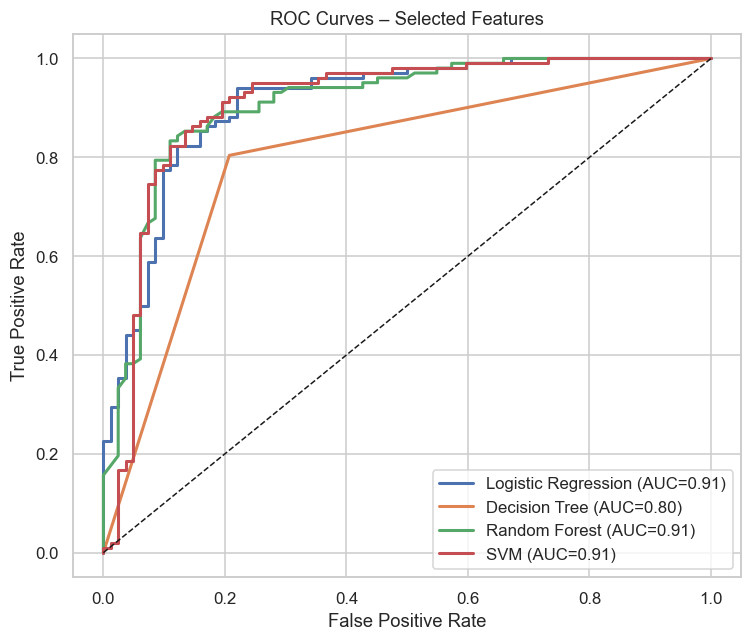

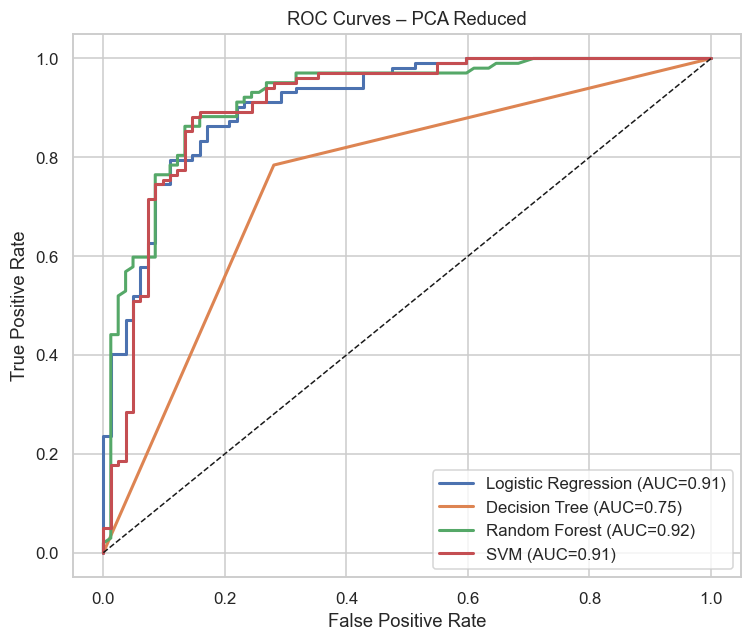

In [16]:
def plot_rocs(roc_dict, title):
    plt.figure(figsize=(7,6))
    for name, (fpr, tpr, auc) in roc_dict.items():
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc:.2f})')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

plot_rocs(sel_roc, 'ROC Curves – Selected Features')
plot_rocs(pca_roc, 'ROC Curves – PCA Reduced')

## 8. Comparison Tables

In [17]:
sel_metrics_named = sel_metrics.copy(); sel_metrics_named.index = [f'Selected | {m}' for m in sel_metrics_named.index]
pca_metrics_named = pca_metrics.copy(); pca_metrics_named.index = [f'PCA | {m}' for m in pca_metrics_named.index]
combined_metrics = pd.concat([sel_metrics_named, pca_metrics_named])
print('Combined Metrics (Both Representations):')
display(combined_metrics.round(4))

# Best per representation by AUC
best_sel = sel_metrics.sort_values('AUC', ascending=False).head(1)
best_pca = pca_metrics.sort_values('AUC', ascending=False).head(1)
summary_best = pd.concat([best_sel, best_pca])
summary_best.index = ['Selected | ' + summary_best.index[0], 'PCA | ' + summary_best.index[1]]
print('Best Models (Per Representation):')
display(summary_best.round(4))

Combined Metrics (Both Representations):


,Accuracy,Precision,Recall,F1,AUC
Selected | Logistic Regression,0.8478,0.8364,0.9020,0.8679,0.9099
Selected | Random Forest,0.8533,0.8505,0.8922,0.8708,0.9080
Selected | SVM,0.8533,0.8319,0.9216,0.8744,0.9079
Selected | Decision Tree,0.7989,0.8283,0.8039,0.8159,0.7983
PCA | Random Forest,0.8370,0.8333,0.8824,0.8571,0.9186
PCA | Logistic Regression,0.8370,0.8333,0.8824,0.8571,0.9116
PCA | SVM,0.8424,0.8067,0.9412,0.8688,0.9079
PCA | Decision Tree,0.7554,0.7767,0.7843,0.7805,0.7519


Best Models (Per Representation):


,Accuracy,Precision,Recall,F1,AUC
Selected | Logistic Regression,0.8478,0.8364,0.9020,0.8679,0.9099
PCA | Random Forest,0.8370,0.8333,0.8824,0.8571,0.9186


## 9. Final Summary

The above evaluation contrasts classical models on raw selected features versus PCA components.

**Observations:**
- Logistic Regression often benefits from PCA if multicollinearity is reduced; tree ensembles may prefer original engineered features.
- Use the AUC column in the 'Best Models' table to justify which path (Selected vs PCA) moves forward.

**Next Steps:** Hyperparameter tuning (Grid / Random Search) for the top 1–2 models, probability calibration, and cross-validation stability checks.

Notebook complete (Section 2.4 comparative view).